# Análise dos resultados das redes em conjunto (ensemble)
Retirado e modificado a partir do GitHub do artigo original
https://github.com/polimi-ispl/icpr2020dfdc.git

In [1]:
# Clonar o repositório do projeto TCC
!git clone https://github.com/NathFarinha/TCC_DeepFake_Detection_v1.git

Cloning into 'TCC_DeepFake_Detection_v1'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 70 (delta 8), reused 2 (delta 2), pack-reused 56
Receiving objects: 100% (70/70), 36.23 MiB | 32.60 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [2]:
import os
os.mkdir('/content/results')

In [3]:
import zipfile
with zipfile.ZipFile('/content/TCC_DeepFake_Detection_v1/results_1000_videos_DFDC/results_1000_videos_EfficientNetAutoAttB4.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/results')

with zipfile.ZipFile('/content/TCC_DeepFake_Detection_v1/results_1000_videos_DFDC/results_1000_videos_EfficientNetAutoAttB4ST.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/results')

with zipfile.ZipFile('/content/TCC_DeepFake_Detection_v1/results_1000_videos_DFDC/results_1000_videos_EfficientNetB4.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/results')

with zipfile.ZipFile('/content/TCC_DeepFake_Detection_v1/results_1000_videos_DFDC/results_1000_videos_EfficientNetB4ST.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/results')

with zipfile.ZipFile('/content/TCC_DeepFake_Detection_v1/results_1000_videos_DFDC/results_1000_videos_Xception.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/results')

In [6]:
import os  # Módulo para interagir com o sistema operacional

# Lista de nomes de arquivos a serem removidos
arquivos_a_remover = [
    'net-EfficientNetAutoAttB4ST_traindb-dfdc-35-5-10_face-scale_size-224_seed-41_bestval/dfdc-35-5-10_val.pkl',
    'net-EfficientNetAutoAttB4_traindb-dfdc-35-5-10_face-scale_size-224_seed-41_bestval/dfdc-35-5-10_val.pkl',
    'net-EfficientNetB4ST_traindb-dfdc-35-5-10_face-scale_size-224_seed-41_bestval/dfdc-35-5-10_val.pkl',
    'net-EfficientNetB4_traindb-dfdc-35-5-10_face-scale_size-224_seed-41_bestval/dfdc-35-5-10_val.pkl',
    'net-Xception_traindb-dfdc-35-5-10_face-scale_size-224_seed-41_bestval/dfdc-35-5-10_val.pkl'
]

# Itera sobre a lista de nomes de arquivos e remove cada um deles
for arquivo in arquivos_a_remover:
    caminho_do_arquivo = os.path.join('/content/results', arquivo)
    if os.path.exists(caminho_do_arquivo):
        os.remove(caminho_do_arquivo)


## Libraries loading

In [7]:
%matplotlib inline
import ntpath
import os
from itertools import combinations
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as M
from scipy.special import expit
from sklearn.metrics import log_loss
from tqdm.notebook import tqdm

## Parameters

In [8]:
results_root = Path('/content/results/')
results_model_folder = list(results_root.glob('net-*'))
column_list = ['video', 'score', 'label']
do_distplot = False

## Helper functions

In [9]:
def compute_metrics(df_res:pd.DataFrame,train_tag:str) -> dict:
    numreal = sum(df_res['label']==False)
    numfake = sum(df_res['label']==True
)

    netname = train_tag.split('net-')[1].split('_')[0]
    traindb = train_tag.split('traindb-')[1].split('_')[0]

    loss = M.log_loss(df_res['label'],expit(df_res['score']))
    acc = M.accuracy_score(df_res['label'],df_res['score']>0)
    accbal = M.balanced_accuracy_score(df_res['label'],df_res['score']>0)
    rocauc = M.roc_auc_score(df_res['label'],df_res['score'])

    res_dict = {'traintag':train_tag,
                'net':netname,
                'traindb': traindb,
                'testdb':testdb,'testsplit':testsplit,
                'numreal':numreal,'numfake':numfake,
                'loss':loss,
                'acc':acc,'accbal':accbal,
                'rocauc':rocauc}
    return res_dict

In [10]:
def get_df(video_all_df, dataset):
    selected_df = video_all_df.loc[dataset].unstack(['model'])['score']
    models = selected_df.columns
    aux_df = video_all_df.loc[dataset].unstack(['model'])['video']
    selected_df['video'] = aux_df[aux_df.columns[0]]
    selected_df['label'] = video_all_df.loc[dataset].unstack(['model'])['label'].mean(axis=1)
    mapper = dict()
    for model in models:
        mapper[model] = model.split('net-')[1].split('_traindb')[0]
    selected_df = selected_df.rename(mapper, axis=1)
    return selected_df

## Load data

In [11]:
# Load data in multi-index dataframe
if os.path.exists('data_frame_df.pkl'):
    data_frame_df = pd.read_pickle('data_frame_df.pkl')
    model_list = []
    for model_folder in tqdm(results_model_folder):
        dataset_list = []
        train_model_tag = model_folder.name
        model_results = model_folder.glob('*.pkl')
        for model_path in model_results:
            dataset_tag = os.path.splitext(ntpath.split(model_path)[1])[0]
            dataset_list.append(dataset_tag)
        model_list.append(train_model_tag)
else:
    data_model_list = []
    model_list = []
    for model_folder in tqdm(results_model_folder):
        data_dataset_list = []
        dataset_list = []
        train_model_tag = model_folder.name
        model_results = model_folder.glob('*.pkl')
        for model_path in model_results:
            netname = train_model_tag.split('net-')[1].split('_')[0]
            traindb = train_model_tag.split('traindb-')[1].split('_')[0]
            testdb, testsplit = model_path.with_suffix('').name.rsplit('_',1)
            dataset_tag = os.path.splitext(ntpath.split(model_path)[1])[0]
            df_frames = pd.read_pickle(model_path)[column_list]
            # Add info on training and test datasets
            df_frames['netname'] = netname
            df_frames['train_db'] = traindb
            df_frames['test_db'] = testdb
            df_frames['test_split'] = testsplit
            data_dataset_list.append(df_frames)
            dataset_list.append(dataset_tag)
        data_model_list.append(pd.concat(data_dataset_list, keys=dataset_list, names=['dataset']))
        model_list.append(train_model_tag)
    data_frame_df = pd.concat(data_model_list, keys=model_list, names=['model']).swaplevel(0, 1)
    data_frame_df.to_pickle('data_frame_df.pkl')

  0%|          | 0/5 [00:00<?, ?it/s]

### Remove cross-test

In [12]:
idx_same_train_test = data_frame_df['train_db'] == data_frame_df['test_db']
data_frame_df = data_frame_df.loc[idx_same_train_test]

### Eliminate Xception experiments, consider only test sets

In [13]:
data_frame_df = data_frame_df[data_frame_df['test_split']=='test']
dataset_list = [x for x in dataset_list if "_val" not in x]
print('Datasets considered are {}'.format(dataset_list))
model_selection_list = ['EfficientNetB4', 'EfficientNetAutoAttB4', 'EfficientNetB4ST', 'EfficientNetAutoAttB4ST']
xception_df = data_frame_df[data_frame_df['netname'].isin(['Xception'])]
data_frame_df = data_frame_df[data_frame_df['netname'].isin(model_selection_list)]
model_list = data_frame_df.index.get_level_values(1).unique()
print('Models considered are {}'.format(data_frame_df['netname'].unique()))

Datasets considered are ['dfdc-35-5-10_test']
Models considered are ['EfficientNetAutoAttB4ST' 'EfficientNetB4' 'EfficientNetAutoAttB4'
 'EfficientNetB4ST']


In [14]:
selected_df = get_df(data_frame_df, dataset='dfdc-35-5-10_test')
selected_df.head()

model,EfficientNetAutoAttB4ST,EfficientNetB4,EfficientNetAutoAttB4,EfficientNetB4ST,video,label
facepath,,,,,,
dfdc_train_part_41/jfglfhocla.mp4/fr000_subj0.jpg,-1.572206,-0.011321,1.474303,0.216210,jfglfhocla.mp4,1.0
dfdc_train_part_41/jfglfhocla.mp4/fr009_subj0.jpg,-0.092877,2.228481,2.693074,1.761865,jfglfhocla.mp4,1.0
dfdc_train_part_41/jfglfhocla.mp4/fr019_subj0.jpg,0.259030,2.137311,2.686251,1.835903,jfglfhocla.mp4,1.0
dfdc_train_part_41/jfglfhocla.mp4/fr028_subj0.jpg,0.309318,3.194729,3.822523,2.293669,jfglfhocla.mp4,1.0
dfdc_train_part_41/jfglfhocla.mp4/fr038_subj0.jpg,0.858229,1.789018,2.061762,1.629130,jfglfhocla.mp4,1.0


## Pair plot per-frame

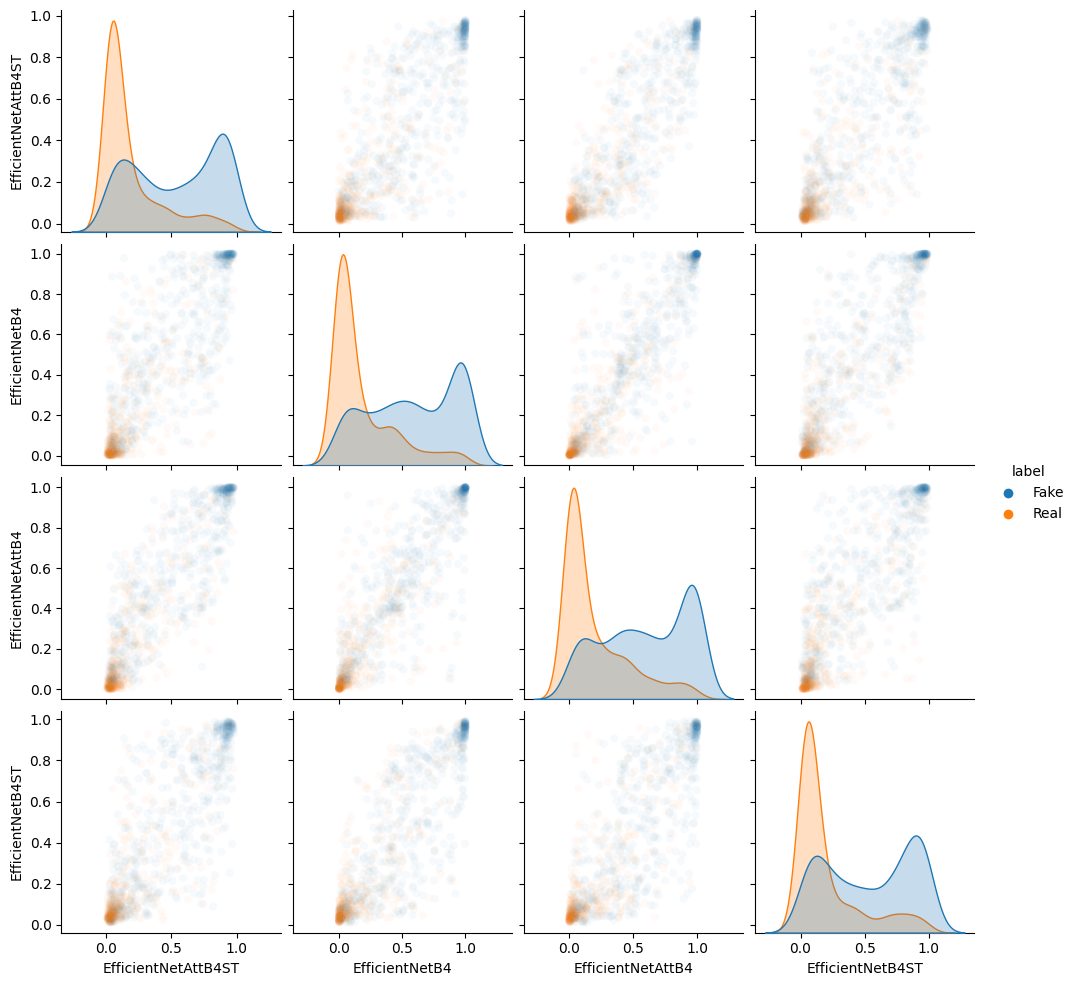

In [16]:
# DFDC
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # Importa o módulo para criar patches (retângulos coloridos)

net_list = list(data_frame_df['netname'].unique())
selected_df = get_df(data_frame_df, dataset='dfdc-35-5-10_test')
selected_df[net_list] = selected_df[net_list].apply(expit)
selected_df = selected_df.rename(columns={'EfficientNetAutoAttB4': 'EfficientNetAttB4',
                                          'EfficientNetAutoAttB4ST': 'EfficientNetAttB4ST'})
selected_df = selected_df.sample(n=1000, random_state=0)
selected_df = selected_df.drop(columns=['video'])

selected_df['label'] = selected_df['label'].apply(lambda x: 'Fake' if x == 1 else 'Real')
g = sns.pairplot(selected_df, hue='label', plot_kws=dict(alpha=0.03))

# Criar uma legenda personalizada
fake_patch = mpatches.Patch(color=sns.color_palette()[0], label='Fake')
real_patch = mpatches.Patch(color=sns.color_palette()[1], label='Real')

# Salvar a imagem do pairplot
plt.savefig('Pair_plot_per-frame_DFDC_with_legend.png')

# Mostrar o gráfico (opcional)
plt.show()


## Pair plot per-video


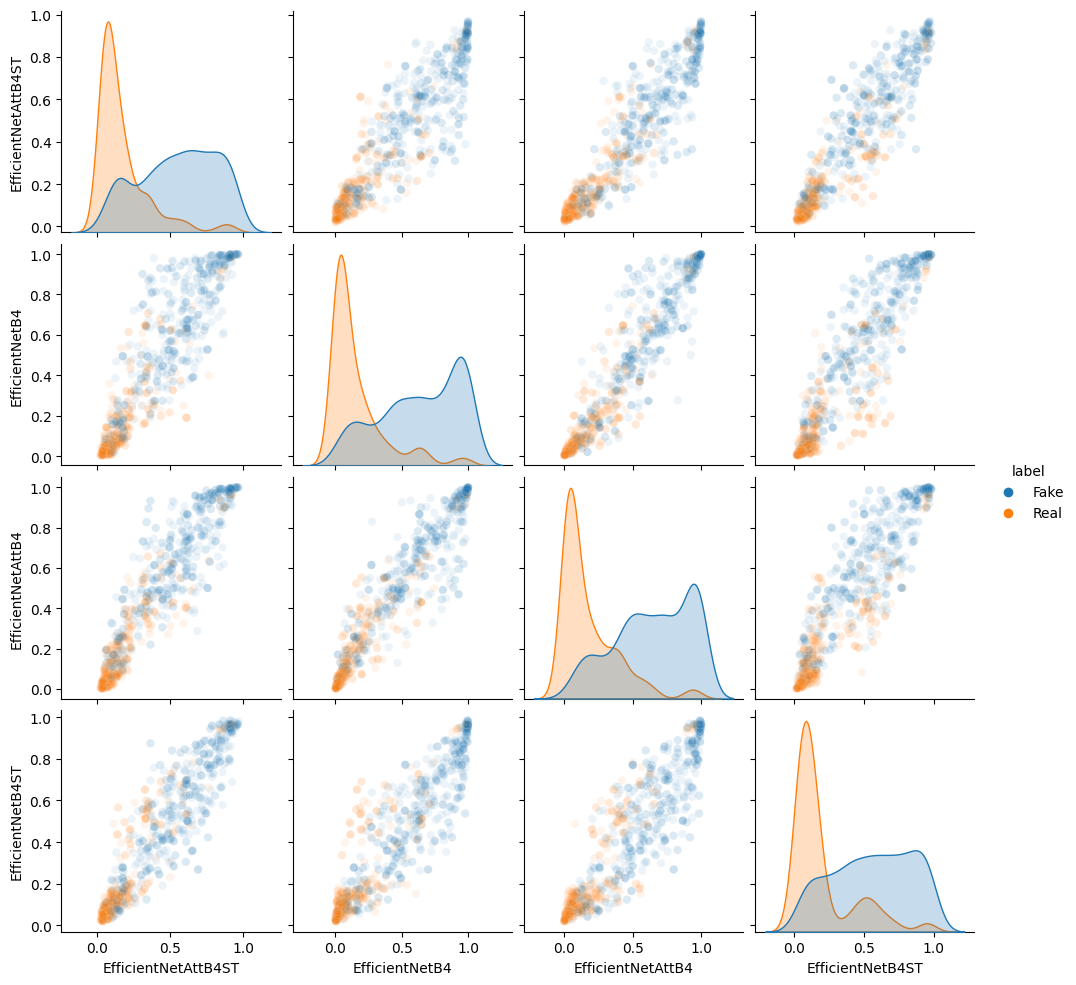

In [18]:
# DFDC
import seaborn as sns
import matplotlib.pyplot as plt

net_list = list(data_frame_df['netname'].unique())
selected_df = get_df(data_frame_df, dataset='dfdc-35-5-10_test')
selected_df = selected_df.groupby('video')
selected_df_video = selected_df.mean().apply(expit)
selected_df_video = selected_df_video.rename(columns={'EfficientNetAutoAttB4': 'EfficientNetAttB4',
                                          'EfficientNetAutoAttB4ST': 'EfficientNetAttB4ST'})
selected_df_video = selected_df_video.sample(n=1000, random_state=0,replace=True)

selected_df_video['label'] = selected_df['label'].mean().apply(lambda x: 'Fake' if x==1 else 'Real')
g = sns.pairplot(selected_df_video, hue='label', plot_kws=dict(alpha=0.08))
#g._legend.remove()

# Salvar a imagem do pairplot
plt.savefig('Pair_plot_per-video_DFDC_with_legend.png')

# Mostrar o gráfico (opcional)
plt.show()

## Xception per-frame

In [19]:
net_list = ['Xception']
comb_list = list(combinations(net_list, 1))
iterables = [dataset_list, ['loss', 'auc']]
index = pd.MultiIndex.from_product(iterables, names=['dataset', 'metric'])
results_x_df = pd.DataFrame(index=index, columns=comb_list)

In [20]:
for dataset in dataset_list:
    print(dataset)
    for model_comb in tqdm(comb_list):
        df = get_df(xception_df, dataset)
        results_x_df[model_comb][dataset, 'loss'] = log_loss(df['label'], expit(np.mean(df[list(model_comb)],
                                                                                      axis=1)))
        results_x_df[model_comb][dataset, 'auc'] = M.roc_auc_score(df['label'], expit(np.mean(df[list(model_comb)],
                                                                                            axis=1)))

dfdc-35-5-10_test


  0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
results_x_df.T

dataset     dfdc-35-5-10_test          
metric                   loss       auc
(Xception,)          1.083138  0.616331

## Xception per-video

In [22]:
net_list = ['Xception']
comb_list = list(combinations(net_list, 1))
iterables = [dataset_list, ['loss', 'auc']]
index = pd.MultiIndex.from_product(iterables, names=['dataset', 'metric'])
results_x_df = pd.DataFrame(index=index, columns=comb_list)

In [23]:
for dataset in dataset_list:
    print(dataset)
    for model_comb in tqdm(comb_list):
        df = get_df(xception_df, dataset)
        df = df.groupby('video')
        df = df.mean()
        results_x_df[model_comb][dataset, 'loss'] = log_loss(df['label'], expit(np.mean(df[list(model_comb)],
                                                                                      axis=1)))
        results_x_df[model_comb][dataset, 'auc'] = M.roc_auc_score(df['label'], expit(np.mean(df[list(model_comb)],
                                                                                            axis=1)))

dfdc-35-5-10_test


  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
results_x_df.T

dataset     dfdc-35-5-10_test          
metric                   loss       auc
(Xception,)          0.948305  0.644406

## Combinations per-frame

In [25]:
net_list = list(data_frame_df['netname'].unique())
comb_list_1 = list(combinations(net_list, 1))
comb_list_2 = list(combinations(net_list, 2))
comb_list_3 = list(combinations(net_list, 3))
comb_list_4 = list(combinations(net_list, 4))
comb_list = comb_list_1 + comb_list_2 + comb_list_3 + comb_list_4
iterables = [dataset_list, ['loss', 'auc']]
index = pd.MultiIndex.from_product(iterables, names=['dataset', 'metric'])
results_df = pd.DataFrame(index=index, columns=comb_list)

In [26]:
for dataset in dataset_list:
    print(dataset)
    for model_comb in tqdm(comb_list):
        df = get_df(data_frame_df, dataset)
        results_df[model_comb][dataset, 'loss'] = log_loss(df['label'], expit(np.mean(df[list(model_comb)],
                                                                                      axis=1)))
        results_df[model_comb][dataset, 'auc'] = M.roc_auc_score(df['label'], expit(np.mean(df[list(model_comb)],
                                                                                            axis=1)))

dfdc-35-5-10_test


  0%|          | 0/15 [00:00<?, ?it/s]

In [27]:
results_df.T

dataset                                            dfdc-35-5-10_test          
metric                                                          loss       auc
(EfficientNetAutoAttB4ST,)                                  0.653387  0.817447
(EfficientNetB4,)                                            0.62217  0.842925
(EfficientNetAutoAttB4,)                                    0.595496  0.839287
(EfficientNetB4ST,)                                         0.677728  0.801851
(EfficientNetAutoAttB4ST, EfficientNetB4)                   0.603688  0.844425
(EfficientNetAutoAttB4ST, EfficientNetAutoAttB4)            0.598935   0.83963
(EfficientNetAutoAttB4ST, EfficientNetB4ST)                 0.639891  0.820798
(EfficientNetB4, EfficientNetAutoAttB4)                     0.587771  0.848945
(EfficientNetB4, EfficientNetB4ST)                          0.625199    0.8343
(EfficientNetAutoAttB4, EfficientNetB4ST)                   0.605635  0.834693
(EfficientNetAutoAttB4ST, EfficientNetB4, Effic...          0.587858  0.847938
(EfficientNetAutoAttB4ST, EfficientNetB4, Effic...          0.613158  0.837795
(EfficientNetAutoAttB4ST, EfficientNetAutoAttB4...          0.605299  0.836364
(EfficientNetB4, EfficientNetAutoAttB4, Efficie...          0.597675  0.842856
(EfficientNetAutoAttB4ST, EfficientNetB4, Effic...          0.596385  0.843258

## Combinations per-video

In [28]:
net_list = list(data_frame_df['netname'].unique())
comb_list_1 = list(combinations(net_list, 1))
comb_list_2 = list(combinations(net_list, 2))
comb_list_3 = list(combinations(net_list, 3))
comb_list_4 = list(combinations(net_list, 4))
comb_list = comb_list_1 + comb_list_2 + comb_list_3 + comb_list_4
iterables = [dataset_list, ['loss', 'auc']]
index = pd.MultiIndex.from_product(iterables, names=['dataset', 'metric'])
results_df = pd.DataFrame(index=index, columns=comb_list)

In [29]:
for dataset in dataset_list:
    print(dataset)
    for model_comb in tqdm(comb_list):
        df = get_df(data_frame_df, dataset)
        df = df.groupby('video')
        df = df.mean()
        results_df[model_comb][dataset, 'loss'] = log_loss(df['label'], expit(np.mean(df[list(model_comb)],
                                                                                      axis=1)))
        results_df[model_comb][dataset, 'auc'] = M.roc_auc_score(df['label'], expit(np.mean(df[list(model_comb)],
                                                                                            axis=1)))

dfdc-35-5-10_test


  0%|          | 0/15 [00:00<?, ?it/s]

In [30]:
results_df.T

dataset                                            dfdc-35-5-10_test          
metric                                                          loss       auc
(EfficientNetAutoAttB4ST,)                                  0.520708  0.895668
(EfficientNetB4,)                                           0.469338  0.909144
(EfficientNetAutoAttB4,)                                    0.436078  0.916074
(EfficientNetB4ST,)                                         0.542163  0.869262
(EfficientNetAutoAttB4ST, EfficientNetB4)                   0.477357  0.910252
(EfficientNetAutoAttB4ST, EfficientNetAutoAttB4)            0.464662  0.912995
(EfficientNetAutoAttB4ST, EfficientNetB4ST)                 0.523929  0.887554
(EfficientNetB4, EfficientNetAutoAttB4)                     0.444198  0.916535
(EfficientNetB4, EfficientNetB4ST)                          0.490748  0.900248
(EfficientNetAutoAttB4, EfficientNetB4ST)                   0.474593  0.903302
(EfficientNetAutoAttB4ST, EfficientNetB4, Effic...          0.457846  0.915416
(EfficientNetAutoAttB4ST, EfficientNetB4, Effic...          0.492492  0.902554
(EfficientNetAutoAttB4ST, EfficientNetAutoAttB4...          0.483471  0.904045
(EfficientNetB4, EfficientNetAutoAttB4, Efficie...          0.465742   0.90946
(EfficientNetAutoAttB4ST, EfficientNetB4, Effic...          0.472715  0.908941